In [1]:
cd("$(homedir())/Documents/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lihel\Documents\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

In [3]:
# read input data
df_data = CSV.read("data/sst_34_anomaly_embedded.txt", DataFrame; delim=',', ignorerepeated=true)
df_train_data = CSV.read("data/train_sst_34_anomaly_embedded_15_04.txt", DataFrame; delim=',', ignorerepeated=true)
df_val_data = CSV.read("data/val_sst_34_anomaly_embedded_15_04.txt", DataFrame; delim=',', ignorerepeated=true)
df_test_data = CSV.read("data/test_sst_34_anomaly_embedded_15_04.txt", DataFrame; delim=',', ignorerepeated=true)

Row,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,Float64
1,-0.04,-1.05,-0.68,-0.84,0.88
2,-0.19,-0.83,-0.62,-0.69,1.07
3,-0.28,-0.71,-0.98,-0.44,1.3
4,-0.27,-0.89,-0.93,-0.01,1.53
5,-0.77,-0.95,-0.85,0.19,1.59
6,-0.85,-1.05,-0.93,0.47,1.9
7,-1.05,-0.68,-0.84,0.88,1.99
8,-0.83,-0.62,-0.69,1.07,1.78
9,-0.71,-0.98,-0.44,1.3,1.53


In [4]:
# bring data into correct format
data = Matrix(transpose(Matrix(df_data)))
train_data = Matrix(transpose(Matrix(df_train_data)))
val_data = Matrix(transpose(Matrix(df_val_data)))
test_data = Matrix(transpose(Matrix(df_test_data)))

5×20 Matrix{Float64}:
 -0.04  -0.19  -0.28  -0.27  -0.77  …  -0.93  -0.85  -0.93  -0.84  -0.69
 -1.05  -0.83  -0.71  -0.89  -0.95     -0.01   0.19   0.47   0.88   1.07
 -0.68  -0.62  -0.98  -0.93  -0.85      1.53   1.59   1.9    1.99   1.78
 -0.84  -0.69  -0.44  -0.01   0.19      1.24   0.81   0.31   0.24   0.21
  0.88   1.07   1.3    1.53   1.59     -0.15  -0.28  -0.14  -0.62  -0.71

Choice of hyperparameter grid: 
- Big reservoir sizes cause singular matrices in the linear regression (due to too little training data), thus we adapt the reservoir size to be smaller.
- we see that res_sizes around 100 are favoured and adapt the grid accordingly.
- to ensure the Echo State Property the spectral radius should be smaller than one (unless long memory is required). As we have little data, we expect that a spectral radius close to one suffices. We try out different combinations
- a sparsity of 0.1 is usually recommended, we test different values around 0.1
- a input scale of 0.1 is recommended by the literature
- we try ridge params as given in the lecture

In [5]:
reservoir_sizes = [60, 70, 80, 90, 95, 100, 105, 110, 115, 120, 130]
spectral_radii = [0.8, 0.9, 1.0, 1.1]
sparsities = [0.05, 0.08, 0.1, 0.12, 0.14]
input_scales = [0.1]
ridge_values = [0.0, 1e-6, 1e-5]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

660-element Vector{Any}:
 enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(70, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(80, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(90, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(95, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(105, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(115, 0.8, 0.05, 0.1, 0.0)
 enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
 ⋮
 enso_project.ESNHyperparams(80, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(90, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(95, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(100, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(105, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(110, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperparams(115, 1.1, 0.14, 0.1, 1.0e-5)
 enso_project.ESNHyperpa

In [6]:
esn, W_out = enso_project.cross_validate_esn(train_data, val_data, param_grid)

enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
Validation loss = 111.87232633779486
enso_project.ESNHyperparams(60, 0.9, 0.05, 0.1, 0.0)
Validation loss = 108.86081772003209
enso_project.ESNHyperparams(60, 1.0, 0.05, 0.1, 0.0)
Validation loss = 100.50334464704456
enso_project.ESNHyperparams(70, 0.8, 0.08, 0.1, 0.0)
Validation loss = 92.39683258389275
enso_project.ESNHyperparams(60, 0.8, 0.1, 0.1, 0.0)
Validation loss = 81.12025268406128
enso_project.ESNHyperparams(60, 0.8, 0.1, 0.1, 1.0e-6)
Validation loss = 80.52889711820451
enso_project.ESNHyperparams(60, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 76.18583780275873


(ESN(5 => 60), OutputLayer successfully trained with output size: 5)

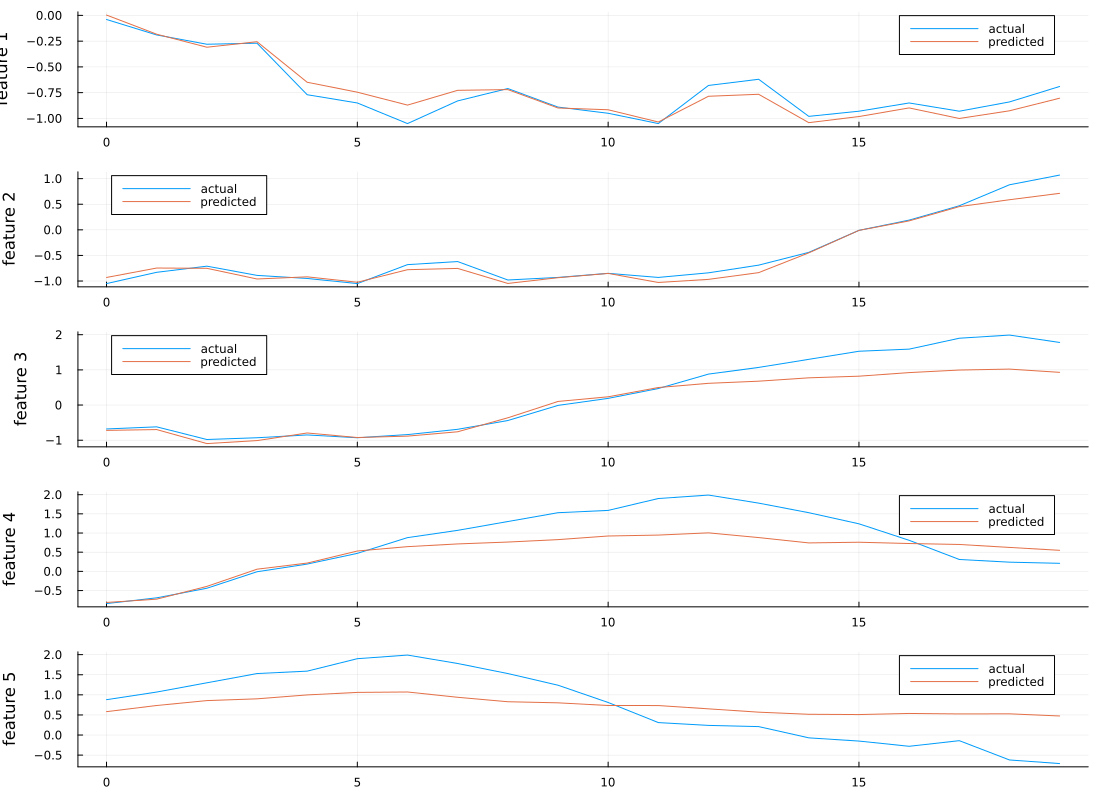

In [7]:
enso_project.plot_prediction(esn, W_out, test_data)

We now also plot the ESN against the validation data set.

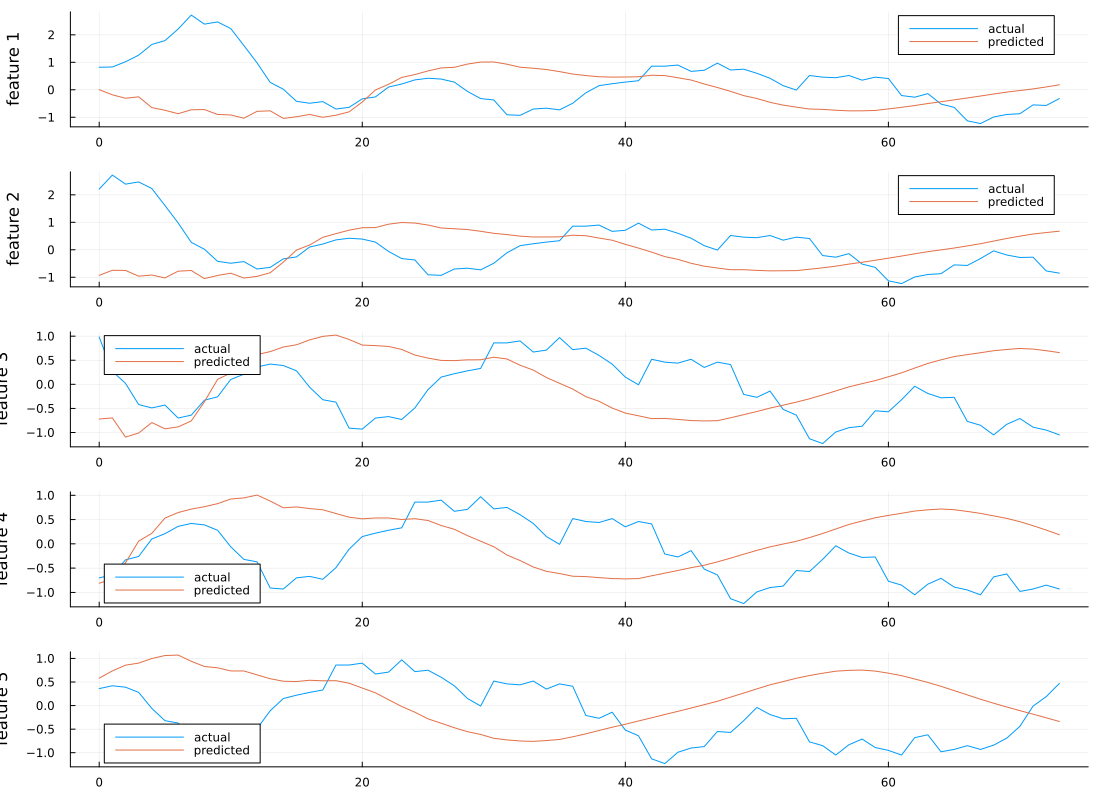

In [9]:
enso_project.plot_prediction(esn, W_out, val_data)